# Computational Finance
## Lab Assignment 1
### Adrian + Daan + Menno 

In [66]:
import numpy as np
import math
from scipy.stats import norm
import matplotlib.pyplot as plt

### 1. Option Valuation using Binomial Trees

We are trying to provide the risk-free fair price for an Option Call, a financial derivative that gives the option holder the right to buy an underlying security at one or many future events.

We assume:

- A two state economy, the price of the underlying can go up or down
- Money can be invested risk free for a constant interest rate
- There is no arbitrage or transaction costs

In [304]:
def binomialTree(S, sigma, T, N, r, K, option_type='Call', origin = 'European'):
    # Time step
    dt = T / N

    # Possible price movements
    u = np.exp(sigma * np.sqrt(dt))
    d = np.exp(-sigma * np.sqrt(dt))

    # Matrix that will hold the values
    matrix = tree = np.zeros((N + 1, N + 1))

    matrix[0, 0] = S

    # Populate the matrix with the stock price progression
    for i in np.arange(1, N + 1): # iterate over rows
        for j in np.arange(i + 1): # iterate over columns
            if j == 0:
                matrix[i, j] = matrix[i-1, j] * d
            else:
                matrix[i, j] = matrix[i-1, j-1] * u

    # Price at each step
    p = (np.exp(r*dt) - d) / (u - d)

    # Hedge amount at each step
    # delta = (up - down) / (s * u - s * d)
    tree = matrix
    columns = tree.shape[1] 
    rows = tree.shape[0]

    # Calculate the price for the expiration day nodes
    for c in np.arange(columns):
        S = tree[rows - 1, c] # Value in the matrix
        if option_type == 'Call':
            tree[rows - 1, c] =  max(0, S - K) 
        else: 
            tree[rows - 1, c] =  max(0, K - S) # Put option

    # Backwards Induction through the nodes
    for i in np.arange(rows - 1)[:: -1]:
        for j in np.arange(i + 1):
            down = tree[i + 1, j]
            up = tree[i + 1, j + 1]
            if origin == "European":

                tree[i, j] = np.exp(-r*dt) * (p * up + (1-p) * down)

            elif origin == 'American':
                tree[i, j] = max(tree[i, j] - K, np.exp(-r*dt) * (p * up + (1-p) * down))

    fu = tree[1][1]
    fd = tree[1][0]

    delta = (fu - fd) / (100 * u - 100 * d)
    
    return tree[0][0], delta

In [305]:
def blackSholes(S, K, t, r, sigma, option_type='Call'):
    # Time to maturity
    tau = T - t

    # Parameters
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)

    # Hedge amount at t
    delta = norm.cdf(d1)

    if option_type == 'Call':
        call_price = S * norm.cdf(d1) - np.exp(-r*tau) * K * norm.cdf(d2)
        return call_price, delta
    else:
        put_price = (np.exp(-r*tau) * K * norm.cdf(-d2)) - (S * norm.cdf(-d1))
        return put_price, delta

In [306]:
# Option Parameters
S = S0 = 100 # Starting stock price
K = 99 # Strike price
T = 1 # Time of maturity
t = 0 # Current period
N = 50 # Amount of steps, possible price changes
r = 0.06 # Risk free interest rate
sigma = vol = 0.2 # Volatility of the stock

In [307]:
test_bt = binomialTree(S, sigma, T, N, r, K)
print(test_bt[0])

test_bs = blackSholes(S, K, t, r, sigma)
print(test_bs[0])

11.546434850755034
11.544280227051097


In [308]:
def plot_errors(max_steps=500):
    bs_price = blackSholes(S, K, t, r, sigma)[0]
    errors = []
    steps = []

    for N in range(30, max_steps, 5):
        errors.append(abs(bs_price-binomialTree(S, sigma, T, N, r, K)))
        steps.append(N)
    plt.plot(steps,errors)
    plt.xlabel('Step')
    plt.ylabel('Error')

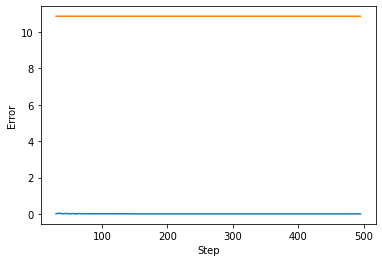

In [309]:
plot_errors()

In [314]:
# 1.2 approximation with different volatilities
# Option Parameters
S = S0 = 100 # Starting stock price
K = 99 # Strike price
T = 1 # Time of maturity
t = 0 # Current period
N = 50 # Amount of steps, possible price changes
r = 0.06 # Risk free interest rate
sigma = vol = 0.2 

def plot_volatilities():
    sigmas = []
    tree_price = []
    bs_price = []
    difference=[]
    for sigma in np.linspace(0, 1, 44):
        bs_price.append(blackSholes(S, K, t, r, sigma)[0])
        tree_price.append(binomialTree(S, sigma, T, N, r, K)[0])
        difference.append(abs(bs_price[-1] - tree_price[-1]))
        sigmas.append(sigma)

    # plt.plot(sigmas,tree_price,label='Binomial Tree')
    # plt.plot(sigmas,tree_price,label='Black-Scholes')
    plt.plot(sigmas, difference)
    plt.xlabel('Volatility', fontsize=12)
    plt.ylabel('Absolute difference in option price', fontsize=12)
    plt.savefig("plots/1b")

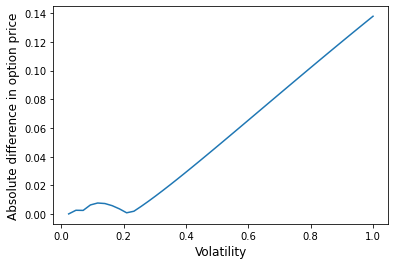

In [315]:
plot_volatilities()

In [313]:
# 1.3
def plot_difference(max_steps=1001):
    bs_price = bs_price = blackSholes(S, K, t, r, sigma)[0]
    tree_price = []
    steps = []
    for N in range(50, max_steps, 5):
        tree_price.append(binomialTree(S, sigma, T, N, r, K)[0])
        steps.append(N)
    plt.plot(steps,tree_price,label='Binomial Tree')
    
    plt.xlabel('Steps', fontsize=12)
    plt.ylabel('Option Price', fontsize=12)
    plt.plot([steps[0],steps[-1]],[bs_price,bs_price],color='Black',label='Black Sholes')
    plt.legend()
    plt.tight_layout()
    # plt.savefig("plots/1c")

[50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000]


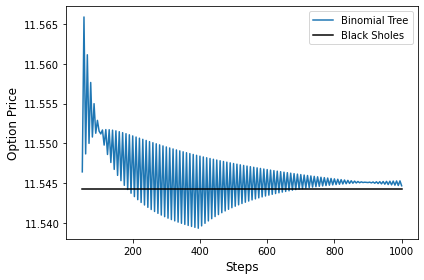

In [301]:
S = S0 = 100 # Starting stock price
K = 99 # Strike price
T = 1 # Time of maturity
t = 0 # Current period
r = 0.06 # Risk free interest rate
sigma = vol = 0.2 
plot_difference()

In [316]:
# 1.5
def plot_volatility():
    sigmas = []
    hedges_bs = []
    hedges_bt = []
    difference = []
    for sigma in np.linspace(0,1,44):
        hedges_bs.append(blackSholes(S, K, t, r, sigma)[1])
        hedges_bt.append(binomialTree(S, sigma, T, N, r, K)[1])
        difference.append(abs(hedges_bs[-1] - hedges_bt[-1]))
        sigmas.append(sigma)

    plt.plot(sigmas, difference)
    plt.xlabel('Volatility', fontsize=12)
    plt.ylabel("Difference in $\Delta_0$", fontsize=12)
    plt.tight_layout()
    # plt.savefig("plots/1e")

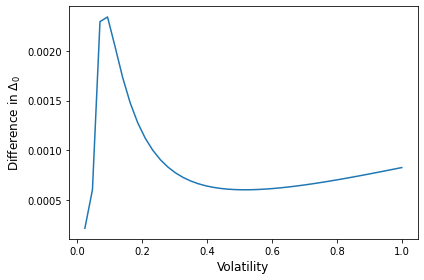

In [317]:
# Option Parameters
S = S0 = 100 # Starting stock price
K = 99 # Strike price
T = 1 # Time of maturity
t = 0 # Current period
N = 50 # Amount of steps, possible price changes
r = 0.06 # Risk free interest rate
sigma = vol = 0.2 
plot_volatility()

In [318]:
def plot_variety():
    a_put = []
    a_call = []
    e_put = []
    e_call = []
    sigmas = []

    for sigma in np.linspace(0,1,44):
        a_put.append(binomialTree(S, sigma, T, N, r, K,option_type='Put', origin = 'American')[0])
        a_call.append(binomialTree(S, sigma, T, N, r, K,option_type='Call', origin = 'American')[0])
        e_put.append(binomialTree(S, sigma, T, N, r, K,option_type='Put', origin = 'European')[0])
        e_call.append(binomialTree(S, sigma, T, N, r, K,option_type='Call', origin = 'European')[0])
        sigmas.append(sigma)
    plt.plot(sigmas,a_put, label='American Put')
    plt.plot(sigmas,a_call, label='American Call')
    plt.plot(sigmas,e_put, label='European Put')
    plt.plot(sigmas,e_call, label='European Call')
    plt.xlabel('Volatility')
    plt.ylabel('Option Price')
    plt.legend()
    # plt.savefig("plots/1f")

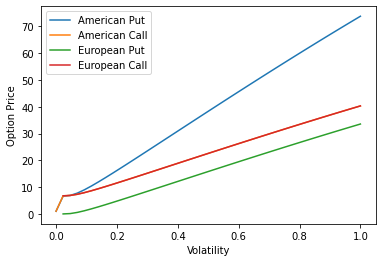

In [296]:
plot_variety()

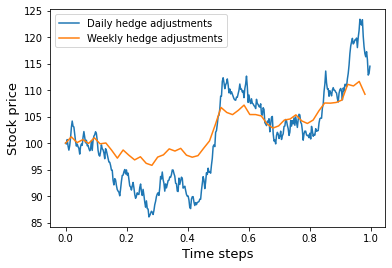

In [321]:
# 2.2
sigma = 0.2
r = 0.06
S0 = 100
K = 99
T = 1

# daily hedging adjustments
day_S = [S0]
M = 365
tau = 1
dt = T/M
day_z = [np.random.normal(0,1) for _ in range(M)]
day_d1s = []

for m in range(M):
    z = day_z[m]
    current_S = day_S[-1]
    S = current_S + r*current_S*dt + sigma * current_S * np.sqrt(dt) * z

    d1 = np.log(S/K) + (r + 0.5 * sigma**2) * tau
    d1 = d1 / (sigma * np.sqrt(tau))

    day_d1s.append(d1)
    day_S.append(S)
    tau -= dt

# weekly hedging adjustments
week_S = [S0]
M = 52
tau = 1
dt = T/M
week_z = [np.mean(day_z[x:x+7]) for x in range(0, len(day_z), 7)]
week_d1s = []

for m in range(M):
    z = week_z[m]
    current_S = week_S[-1]
    S = current_S + r*current_S*dt + sigma * current_S * np.sqrt(dt) * z

    d1 = np.log(S/K) + (r + 0.5 * sigma**2) * tau
    d1 = d1 / (sigma * np.sqrt(tau))

    week_d1s.append(d1)
    week_S.append(S)
    tau -= dt

plt.plot(np.arange(0, 1, 1/366), day_S, label="Daily hedge adjustments")
plt.plot(np.arange(0, 1, 1/53), week_S, label="Weekly hedge adjustments")
plt.xlabel("Time steps", fontsize=13)
plt.ylabel("Stock price", fontsize=13)
plt.legend()
# plt.savefig("plots/2b")

## 2. Black-Scholes model: hedging simulations

Use  the  Euler  method  to  perform  a  hedging  simulation.   Do  an  experiment  where  the volatility in the stock price process is matching the volatility used in the delta computation(set both equal to 20%). Vary the frequency of the hedge adjustment (from daily to weekly)and explain the results.  Perform numerical experiments where the volatility in the stockprice process is not matching the volatility used in the delta valuation.  Experiment forvarious levels and explain the results.

In [ ]:
# Parameter
sigma = 0.2 # Volatility of the stock price
r = 0.06 # Risk free interest rate
S = 100 # Starting stock price
K = 99 # Strike price
T = 1 # Time of maturity
M = 10 # aMount of periods in between option sale and maturity

In [ ]:
all_differences = []
all_2 = []
from tqdm import tqdm
for num in tqdm(range(1000)):
    error = 1

    # Parameter
    sigma = 0.2 # Volatility of the stock price
    r = 0.06 # Risk free interest rate
    S = 100 # Starting stock price
    K = 99 # Strike price
    T = 1 # Time of maturity
    M = 1400 # aMount of periods in between option sale and maturity

    S0 = S

    dt = T/M
    t = 0
    tau = T - t

    all_S = [S0]
    all_m = [0]
    all_delta = [norm.cdf((np.log(S/K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau)))]
    all_delta2 = [norm.cdf((np.log(S/K) + (r + 0.5 * (sigma*error)**2) * tau) / ((sigma*error) * np.sqrt(tau)))]


    option_price = blackSholes(S, K, t, r, sigma)[0]
    # print(option_price, all_delta[0], S)
    wallet = option_price
    holdings = all_delta[0]
    wallet -= (all_delta[0]*all_S[0])

    wallet2 = option_price
    holdings2 = all_delta[0]
    wallet2 -= (all_delta[0]*all_S[0])

    all_holdings = [holdings]
    all_wallet = [wallet]
    # print('H: ',holdings, 'W: ',wallet, 'S: ', S)
    for m in range(M):
            # Sample random value
            z = np.random.normal(0, 1)

            # Stock price calculation
            current_S = all_S[-1]
            S = current_S + r*current_S*dt + sigma * current_S * np.sqrt(dt) * z

            # Hedge
            tau -= dt
            d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
            delta = norm.cdf(d1)

            if m % 7 == 0:
                d12 = (np.log(S/K) + (r + 0.5 * ((sigma*error)**2)) * tau) / ((sigma*error) * np.sqrt(tau))
                delta2 = norm.cdf(d12)

            if np.isnan(delta):
                if all_delta[-1]>0.8:
                    delta =1
                else:
                    delta =0 
            if m % 7 == 0:
                if np.isnan(delta2):
                    if all_delta2[-1]>0.8:
                        delta2 =1
                    else:
                        delta2 =0 
                all_delta2.append(delta2)
            all_delta.append(delta)
            
            difference = holdings-delta
            holdings = delta
            wallet += difference * S
            wallet *= np.exp(r*dt)
            all_S.append(S)
            all_m.append(m)
            
            if m % 7 == 0:
                difference2 = holdings2-delta2
                holdings2 = delta2
                wallet2 += difference2 * S
                wallet2 *= np.exp(r*dt)
            else:
                wallet2 *= np.exp(r*dt)
            # print('H: ',holdings, 'W: ',wallet, 'S: ', S, 'tau: ', tau)
    # print(K, S)
    if S > K:
        # print('cashed')
        if holdings != 1:
            # print('H0000: ',holdings, 'W: ',wallet, 'S: ', S, 'tau: ', tau)
            dif = 1 - holdings
            wallet -= dif * S
            holdings += 1
            # print(holdings == 1, wallet)
        wallet += K
        holdings -= 1
        if holdings2 != 1:
            dif2 = 1 - holdings2
            wallet2 -= dif2 * S
            holdings2 += 1
            # print(holdings2 == 1, wallet2)
        wallet2 += K
        holdings2 -= 1
    # print('H: ',holdings, 'W :',wallet, 'Int: ',(option_price*(np.exp(r))-option_price))
    all_differences.append(wallet)
    all_2.append(wallet2)
    if abs(all_differences[-1])> 3:
        pass
    # print(len(all_delta2),len(all_delta))
        # print('H111: ',holdings, 'W: ',wallet, 'S: ', S, 'tau: ', tau)
    # print(wallet-(option_price*(np.exp(r))-option_price))

In [ ]:
final = []
final2 = []
for dif in all_differences:
    if abs(dif) < 15:
        final.append(dif)
for diff in all_2:
    if abs(diff) < 300:
        final2.append(diff)

    
print(np.mean(all_differences), len(final))
print(np.mean(all_2), len(final2))

In [ ]:
np.mean(all_2)
from matplotlib.pyplot import subplots, show
fig, ax = subplots()
ax.hist(final2,alpha=0.95,bins=100,label='Weekly Hedge')
ax.hist(final,alpha=0.7,bins=20, label= 'Daily Hedge')

ax.set_xlabel("Profit")
ax.set_ylabel("Samples")

plt.legend()
plt.savefig('plots/w_hedge_full.pdf',pad_inches=0.5)
plt.savefig('plots/w_hedge_full.png',pad_inches=0.5)

In [ ]:
from tqdm import tqdm
import pickle

volatilities = [0.25, 0.5, 0.75, 1.5, 2, 3]
for vol in volatilities:

    # Output
    profit = []
    profit_2= []

    for iteration in tqdm(range(1000)):

        # Sigma multiplier
        error = vol

        # Parameters
        sigma = 0.2 # Volatility of the stock price
        r = 0.06 # Risk free interest rate
        S = S0 = 100 # Starting stock price
        K = 99 # Strike price
        T = 1 # Time of maturity
        M = 5000 # aMount of periods in between option sale and maturity
        t = 0

        dt = T/M
        tau = T - t

        # Data Collection
        all_S = [S0]
        all_m = [0]
        all_delta = [norm.cdf((np.log(S/K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau)))]
        all_delta2 = [norm.cdf((np.log(S/K) + (r + 0.5 * (sigma*error)**2) * tau) / ((sigma*error) * np.sqrt(tau)))]

        # Money System
        option_price = blackSholes(S, K, t, r, sigma)[0]
        wallet = option_price
        holdings = all_delta[0]
        wallet -= (all_delta[0]*all_S[0])

        wallet2 = option_price
        holdings2 = all_delta[0]
        wallet2 -= (all_delta[0]*all_S[0])

        for m in range(M):
            # Sample random value
            z = np.random.normal(0, 1)

            # Stock price calculation
            current_S = all_S[-1]
            S = current_S + r*current_S*dt + sigma * current_S * np.sqrt(dt) * z

            # Hedge
            tau -= dt
            d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
            delta = norm.cdf(d1)

            d12 = (np.log(S/K) + (r + 0.5 * ((sigma*error)**2)) * tau) / ((sigma*error) * np.sqrt(tau))
            delta2 = norm.cdf(d12)

            # When delta gets really small numpy turns it into a nan
            if np.isnan(delta):
                if all_delta[-1]>0.8:
                    delta =1
                else:
                    delta =0

            if np.isnan(delta2):
                if all_delta2[-1]>0.8:
                    delta2 =1
                else:
                    delta2 =0

            all_delta.append(delta)
            all_delta2.append(delta2)

            difference = holdings-delta
            holdings = delta
            wallet += difference * S
            wallet *= np.exp(r*dt)

            difference2 = holdings2-delta2
            holdings2 = delta2
            wallet2 += difference2 * S
            wallet2 *= np.exp(r*dt)

            all_S.append(S)
            all_m.append(m)

        if S > K:
            # Cash in the option
            if holdings != 1:
                dif = 1 - holdings
                wallet -= dif * S
                holdings += 1

            wallet += K
            holdings -= 1

            if holdings2 != 1:
                dif2 = 1 - holdings2
                wallet2 -= dif2 * S
                holdings2 += 1

            wallet2 += K
            holdings2 -= 1

        profit.append(wallet)
        profit_2.append(wallet2)
    profit_list = [profit,profit_2]
    with open(str(vol)+'.p', 'wb') as handle:
        pickle.dump(profit_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
final = []
final2 = []
for dif in all_differences:
    if abs(dif) < 10:
        final.append(dif)
for diff in all_2:
    if abs(diff) < 60:
        final2.append(diff)

print(np.mean(all_differences), len(final))
print(np.mean(all_2), len(final2))
np.mean(all_2)

plt.hist(final2,alpha=0.95,bins=20,label='sigma = 0.4')
plt.hist(final,alpha=0.7,bins=20, label= 'sigma = 0.2')

plt.ylabel='Samples'
plt.xlabel='Profit'

plt.legend()

plt.show()

In [ ]:
import pandas as pd
volatilities = [1.5]
df = pd.DataFrame()
datas = []
for vol in volatilities:
    with open(str(vol)+'.p', 'rb') as handle:
        data= pickle.load(handle)
plt.hist(data[1],bins=25,label='False Volatility')
plt.hist(data[0],alpha=0.80,bins=15,label='True Volatility')
plt.xlabel('Profit')
plt.ylabel('Samples')
plt.legend()
plt.savefig('plots/vols_hist.pdf',pad_inches=0.5)
plt.savefig('plots/vols_hist.png',pad_inches=0.5)

In [ ]:
import pandas as pd
volatilities = [0.25, 0.5, 0.75, 1.5, 2, 3]
df = pd.DataFrame()
datas = []
for vol in volatilities:
    with open(str(vol)+'.p', 'rb') as handle:
        data= pickle.load(handle)
    print(type(data))
    i = 0
    for l in data:
       for value in l:
           datas.append([str(vol),value,(i<=1000)])
           i += 1

df = pd.DataFrame(datas, columns = ['volatility_multiplier','Profit','true_volatility'])

In [ ]:
import seaborn as sns
sns.set_palette("coolwarm")
df = df[df.true_volatility == True]
# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="volatility_multiplier", y="Profit",
            # hue='true_volatility',
            data=df,
            showfliers = False)
sns.despine(offset=10, trim=True)
import matplotlib.pyplot as plt
plt.tight_layout()
plt.savefig('plots/vols_sep_0.pdf',pad_inches=0.5)
plt.savefig('plots/vols_sep_0.png',pad_inches=0.5)
plt.show()

In [ ]:
def gbm_euler(S, K, T, M, sigma, r):
    # Time step
    dt = T / M
    tau = 1

    all_S = [S0]
    all_m = [0]
    all_delta = [norm.cdf((np.log(S/K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau)))]
    # Algorithm 2.2
    for m in range(M):
        # Sample random value
        z = np.random.normal(0, 1)

        # Stock pr'ce calculation
        current_S = all_S[-1]
        S = current_S + r*current_S*dt + sigma * current_S * np.sqrt(dt) * z

        # Hedge
        tau -= dt
        d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
        delta = norm.cdf(d1)
        all_delta.append(delta)

        all_S.append(S)
        all_m.append(m)
    return [all_m, all_S, all_delta]
